In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import os, random, json, matplotlib.pyplot as plt
from rapidfuzz import process

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

def get_image_path(name):
    return os.path.join("../data/raw/food-101/images", name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)
test_df["image_path"] = test_df["image_name"].apply(get_image_path)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label_encoded"]))
train_ds = train_ds.map(load_and_preprocess_image).shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["image_path"], test_df["label_encoded"]))
test_ds = test_ds.map(load_and_preprocess_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(len(label_encoder.classes_), activation="softmax")(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,877 (9.96 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("../data/clean/mobilenet_food101_best.keras", save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

model.save("../data/clean/mobilenet_food101_initial.keras")

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.2784 - loss: 3.0741 - val_accuracy: 0.0313 - val_loss: 5.4251 - learning_rate: 1.0000e-04
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 326s 138ms/step - accuracy: 0.3489 - loss: 2.4361 - val_accuracy: 0.0674 - val_loss: 6.0069 - learning_rate: 1.0000e-04
Epoch 3/10
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4741 - loss: 1.7914
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 333s 140ms/step - accuracy: 0.4741 - loss: 1.7913 - val_accuracy: 0.0826 - val_loss: 5.9790 - learning_rate: 1.0000e-04
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 367s 155ms/step - accuracy: 0.4788 - loss: 1.7756 - val_accuracy: 0.1044 - val_loss: 5.4380 - learning_rate: 5.0000e-05
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 334s 141ms/step - accuracy: 0.5136 - loss: 1.6407 - val_accuracy: 0.1105 - val_loss: 5.3517 - learning_rate: 5.0000e-05
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━

In [5]:
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

fine_tune_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop, lr_scheduler]
)

model.save("../data/clean/mobilenet_food101_finetuned.keras")

Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 534s 223ms/step - accuracy: 0.2115 - loss: 3.3197 - val_accuracy: 0.2200 - val_loss: 3.2997 - learning_rate: 1.0000e-05
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 526s 222ms/step - accuracy: 0.2946 - loss: 2.8151 - val_accuracy: 0.1783 - val_loss: 3.6381 - learning_rate: 1.0000e-05
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.3107 - loss: 2.6829
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 525s 221ms/step - accuracy: 0.3107 - loss: 2.6828 - val_accuracy: 0.1611 - val_loss: 3.8612 - learning_rate: 1.0000e-05
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 597s 252ms/step - accuracy: 0.2473 - loss: 2.9870 - val_accuracy: 0.2593 - val_loss: 3.0232 - learning_rate: 5.0000e-06
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 514s 217ms/step - accuracy: 0.2752 - loss: 2.9569 - val_accuracy: 0.3082 - val_loss: 2.7975 - learning_rate: 5.0000e-06
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━

790/790 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.2909 - loss: 2.8481
Final Test Accuracy: 0.3363
Final Test Loss: 2.7297


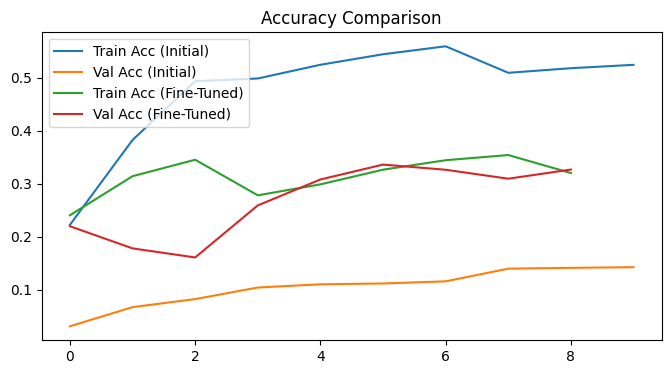

In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Train Acc (Initial)")
plt.plot(history.history["val_accuracy"], label="Val Acc (Initial)")
plt.plot(fine_tune_history.history["accuracy"], label="Train Acc (Fine-Tuned)")
plt.plot(fine_tune_history.history["val_accuracy"], label="Val Acc (Fine-Tuned)")
plt.legend()
plt.title("Accuracy Comparison")
plt.show()

In [12]:
usda_df = pd.read_csv("../data/raw/usda_food_data.csv")

def find_closest_food(food_name):
    descriptions = usda_df["description"].dropna().tolist()
    result = process.extractOne(food_name.replace("_", " "), descriptions)
    if result is None:
        return None
    match, score = result[0], result[1]  
    if score > 70:
        matched_row = usda_df[usda_df["description"].str.contains(match, case=False, na=False)]
        if not matched_row.empty:
            return matched_row.iloc[0]
    return None


def predict_food(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
    pred = model.predict(img_array)
    pred_label = label_encoder.inverse_transform([np.argmax(pred)])[0]

    print(f"Predicted Food: {pred_label}")
    info = find_closest_food(pred_label)
    if info is not None:
        print("\nNutrition Info:")
        print(info[["description", "calories", "protein", "fat", "carbohydrates"]])
    else:
        print("No match found in USDA database.")

    
    plt.imshow(img)
    plt.axis("off")
    plt.title(pred_label)
    plt.show()


Testing image: ../data/raw/food-101/images/filet_mignon/108228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Food: filet_mignon
No match found in USDA database.


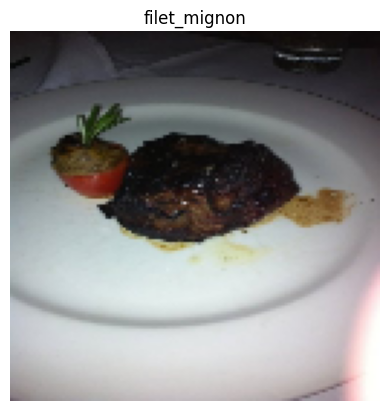


Testing image: ../data/raw/food-101/images/club_sandwich/3896183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Food: grilled_cheese_sandwich

Nutrition Info:
description      Grilled cheese sandwich, NFS
calories                                343.0
protein                                 11.03
fat                                     20.78
carbohydrates                           28.09
Name: 156, dtype: object


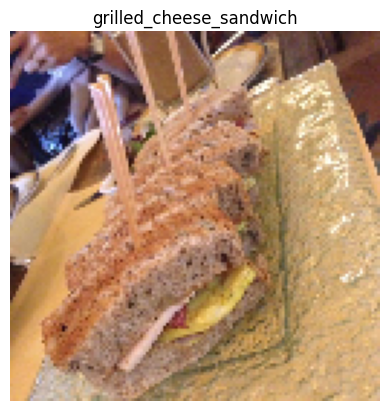


Testing image: ../data/raw/food-101/images/filet_mignon/788488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Food: prime_rib
No match found in USDA database.


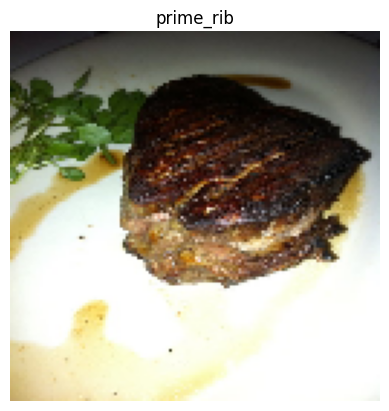


Testing image: ../data/raw/food-101/images/miso_soup/1014272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Food: miso_soup

Nutrition Info:
description      Soup, miso or tofu
calories                       24.0
protein                        2.21
fat                            0.85
carbohydrates                   2.3
Name: 197, dtype: object


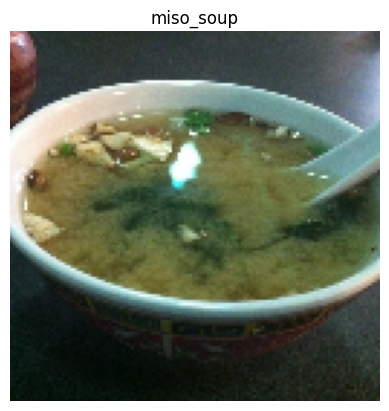


Testing image: ../data/raw/food-101/images/deviled_eggs/2131576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Food: deviled_eggs

Nutrition Info:
description      Egg, deviled
calories                198.0
protein                 11.52
fat                      15.9
carbohydrates            1.07
Name: 92, dtype: object


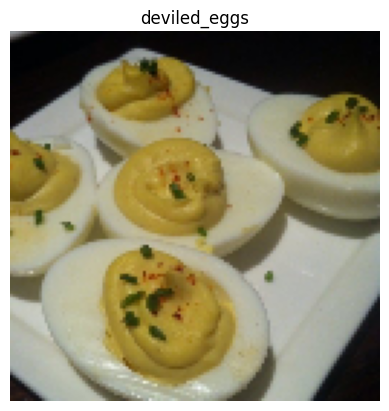

In [14]:
def test_multiple_predictions(num_samples=5):
    sample_paths = random.sample(test_df["image_path"].tolist(), num_samples)

    for path in sample_paths:
        print("\nTesting image:", path)
        predict_food(path)

# Test the model on 5 random images
test_multiple_predictions(num_samples=5)

In [17]:
import json

# Convert all keys and values to native Python types
label_map_serializable = {str(k): int(v) for k, v in label_map.items()}

with open("../data/clean/label_map.json", "w") as f:
    json.dump(label_map_serializable, f, indent=4)

print("Saved model")

Saved model
